# Custom Classifier Training and Testing Module
This code is devided into three sections: 

1. Labeling, in this section you will utilize a User Interfase to label some cells/vacuoles masks to feed in to a machine learning models to train it to recognize these classifications.
2. Training, you will set parameters to your machine learning algorithm and train your model
3. Apply your models to a subset of data to determine the best model and the confidency threshold

In [1]:
# Configuration setup - modify this path according to your setup
CONFIG_FILE_PATH = "config/config.yml"

In [ ]:
# ——— Stdlib ———
import os
import re
import shutil
from glob import glob
from pathlib import Path
import io
from typing import Any, Dict, Iterable, List, Optional, Sequence, Tuple, Union

# ——— Third-party ———
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from IPython.display import display, clear_output, Image as DisplayImage
from PIL import Image as PILImage
import ipywidgets as widgets
import tifffile
from scipy.ndimage import label as cc_label
from skimage import measure, segmentation
import yaml

# ——— Local ———
from lib.shared.configuration_utils import convert_tuples_to_lists
from lib.aggregate.classifier_labeling import (
    _mode_norm,
    _id_col_for_mode,
    _pq_path_for,
    prepare_mask_dataframes,
    consolidate_manual_classifications,
    _ensure_mc_schema,
    _render_next_batch,
    _normalize_keys,
)
from lib.aggregate.apply_classifier import (
    launch_rankline_ui,
    build_montages_and_summary,
    display_pngs_in_plots_and_list_models,
    resolve_classifier_model_dill_path,
    build_master_phenotype_df, show_model_evaluation_pngs
)
from lib.aggregate.confidence_correction import calibrate_confidence
from lib.aggregate.train_classifier import (
    load_cellprofiler_data,
    train_classifier_pipeline,
    filter_classes,
)
from lib.aggregate.cell_data_utils import split_cell_data
from lib.aggregate.cell_classification import CellClassifier

In [3]:
# Load config file
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)

# Set up root paths from config
ROOT_FP = (Path(CONFIG_FILE_PATH).resolve().parent.parent / config["all"]["root_fp"]).resolve()
PHENOTYPE_OUTPUT_FP = ROOT_FP / "phenotype"
PQ_DIR = PHENOTYPE_OUTPUT_FP / "parquets"

In [4]:
# Set up classifier output directory (only this directory is created from this cell)
CLASSIFIER_OUTPUT_DIR = ROOT_FP / "classifier"
CLASSIFIER_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print(f"Created/verified: {CLASSIFIER_OUTPUT_DIR}")

Created/verified: /lab/ops_analysis/lourido/acai/analysis/brieflow_output/classifier


# 1a. Set Classification Paramters

<font color='red'>IF adding additional classification to existing trained data:</font>
1. ```ADD_TRAINING_DATA``` set to ```False``` for firs time training, set to ```True``` if adding additional additional datapoints for trainer. The output will be saved as a new trained model.
2. ```EXISTING_TRAIING_DATA``` only set this is if ```ADD_TRAINING_DATA``` is ```True``` set this to the name of the training dataset that you want to build upon
4. ```RELABEL_CLASSIFICATIONS``` if you would like to revist your labeled data from the existing model, set this to True, previously labeled data will be prioritized.
=================
3. ```CLASSIFY_BY_VACUOLE_OR_CELL``` = ```"vacuole"``` or ```"cell"```
4. ```CLASS_TITLE``` = Name of the new column added to the end of phenotype dataframe
5. ```CLASSIFICATION``` = Catagories you want classify your vacuoles with. Classification will show up as 1, 2, 3...in output parquet, they correspond to the order listed here
6. ```PLATES_TO_CLASSIFY``` = Plates that need to be classified
7. ```WELLS_TO_CLASSIFY``` = Wells among the plates specified above to be classified

In [ ]:
ADD_TRAINING_DATA = True  # set to False to build a new training dataset from scratch
EXISTING_TRAINING_DATA = "vacuole_classifier_training_dataset_for_parasite_count_20250818_002808.parquet"
RELABEL_CLASSIFICATIONS = True  # set to True if you want to change the classification an existing training dataset, otherwise set to False. previously lassified data will show up first if you choose to relabel

CLASSIFY_BY_VACUOLE_OR_CELL = "vacuole" #options are "vacuole" or "cell"
CLASS_TITLE = "parasite_count"
CLASSIFICATION = ["1 parasite", "2-3 parasite", "4-7 parasite", "8+ parasite"]
PLATES_TO_CLASSIFY = ["1", "2"] #Default to all
WELLS_TO_CLASSIFY = ["A1", "A2", "A3"] #Default to all

In [ ]:
# Derived constants
_mode_cfg = str(CLASSIFY_BY_VACUOLE_OR_CELL).strip().lower()
if _mode_cfg not in {"cell", "vacuole"}:
    raise ValueError(f"CLASSIFY_BY_VACUOLE_OR_CELL must be 'cell' or 'vacuole', got: {CLASSIFY_BY_VACUOLE_OR_CELL!r}")

# Validate existing training parquet when ADD_TRAINING_DATA = True
EXISTING_TRAINING_PATH = None
if ADD_TRAINING_DATA:
    if not EXISTING_TRAINING_DATA:
        raise ValueError("ADD_TRAINING_DATA=True but EXISTING_TRAINING_DATA is not provided (filename).")
    train_dir = Path(CLASSIFIER_OUTPUT_DIR) / "training_dataset"
    EXISTING_TRAINING_PATH = train_dir / str(EXISTING_TRAINING_DATA)
    if not EXISTING_TRAINING_PATH.exists():
        raise FileNotFoundError(f"Existing training parquet not found: {EXISTING_TRAINING_PATH}")

    # Parse filename: "{mode}_classifier_training_dataset_for_{CLASS_TITLE}_{stamp}.parquet"
    m = re.match(r"^(cell|vacuole)_classifier_training_dataset_for_(.+?)_\d{8}_\d{6}\.parquet$",
                 EXISTING_TRAINING_PATH.name)
    if not m:
        raise ValueError(
            "EXISTING_TRAINING_DATA filename must match:\n"
            "  '{mode}_classifier_training_dataset_for_{CLASS_TITLE}_{YYYYMMDD}_{HHMMSS}.parquet'"
        )
    mode_from_file = m.group(1)
    class_title_from_file = m.group(2)

    if mode_from_file != _mode_cfg:
        raise ValueError(
            f"Mode mismatch: file says mode='{mode_from_file}', but CLASSIFY_BY_VACUOLE_OR_CELL='{_mode_cfg}'. "
            "Please align your settings with the existing parquet."
        )
    if class_title_from_file != CLASS_TITLE:
        raise ValueError(
            f"CLASS_TITLE mismatch: file says CLASS_TITLE='{class_title_from_file}', but CLASS_TITLE='{CLASS_TITLE}'. "
            "Please align your settings with the existing parquet."
        )
    
# Mapping for UI
class_mapping = {'label_to_class': {i + 1: label for i, label in enumerate(CLASSIFICATION)}}

print("[training] Config OK.",
      f"ADD_TRAINING_DATA={ADD_TRAINING_DATA}, RELABEL_CLASSIFICATIONS={RELABEL_CLASSIFICATIONS}")

In [ ]:
mode = _mode_norm(CLASSIFY_BY_VACUOLE_OR_CELL)
plate_set = [str(p) for p in PLATES_TO_CLASSIFY]
well_set  = list(WELLS_TO_CLASSIFY)

exclude_exact = {
    "plate","well","tile", "vacuole_id","label" # sometimes appears if the index had a name
}

ordered_features, seen = [], set()

for plate in sorted(plate_set):
    for well in sorted(well_set):
        pq_path = _pq_path_for(plate, well, PQ_DIR, mode)
        if not pq_path.exists():
            continue
        # Read schema (no data)
        try:
            import pyarrow.parquet as pq
            cols = pq.ParquetFile(pq_path).schema.names
        except Exception:
            cols = list(pd.read_parquet(pq_path).head(0).columns)

        for col in cols:
            lc = str(col).lower()
            # skip metadata, bounds/location-like, and pandas index artifacts
            if (
                lc in exclude_exact
                or ("bounds" in lc)
                or ("location" in lc)
                or re.fullmatch(r"__index_level_\d+__", lc)  # <-- filters __index_level_0__
            ):
                continue
            if col not in seen:
                seen.add(col)
                ordered_features.append(col)

for name in ordered_features:
    print(name)


# 1b. Set Classification Threshold Paramters

1. ```THRESHOLD_FEATURE``` = Feature you want to threshold with e.g. ```"nucleus_DAPI_mean"``` (optional, only set if you want to select range of tiles to classify) Set a pair of max and mean depending on your threshold format
- ```THRESHOLD_MIN``` sets a numeric minimum, masks lower than this value (inclusive) will not be displayed
- ```THRESHOLD_MAX``` sets a numeric maximum, masks higher than this value (exclusive) will not be displayed
- ```THRESHOLD_MIN_PERCENTILE``` set a percentile minimum (0-1), masks lower than this percentile will not be displayed
- ```THRESHOLD_MAX_PERCENTILE``` set a percentile maximum (0-1), masks higher than this percentile will not be displayed
2. ```BATCH_SIZE``` set the number of images you want to display per round of classification, default to 10. 
2. ```OUT_OF_THRESHOLD_RANDOMIZER``` defaults to ```0```, choose between ranges ```0-BATCH_SIZE```. Out of the images displayed for each round of classification, this many image will be randomly selected from all the masks that are out of the threshold range.

In [ ]:
THRESHOLD_FEATURE = "vacuole_area_x"
THRESHOLD_MIN = None #exclusive
THRESHOLD_MAX = 11600 #inclusive
THRESHOLD_MIN_PERCENTILE = 0.5
THRESHOLD_MAX_PERCENTILE = None
BATCH_SIZE = 10 #how many masks to show at a time in the UI
OUT_OF_THRESHOLD_RANDOMIZER = 1

In [ ]:
_KEYS = ["plate", "well", "tile", "mask_label"]

mask_summary_df, mask_instances_df, mask_instances_out_of_threshold_df, thr_dbg = prepare_mask_dataframes(
    mode=CLASSIFY_BY_VACUOLE_OR_CELL,           # "vacuole" or "cell"
    pq_root=PHENOTYPE_OUTPUT_FP,
    plates=PLATES_TO_CLASSIFY,
    wells=WELLS_TO_CLASSIFY,
    keys=_KEYS,                                 # ["plate","well","tile","mask_label"]
    threshold_feature=THRESHOLD_FEATURE,        # str | list[str] | None
    threshold_min=THRESHOLD_MIN,                # float | list[float] | None
    threshold_max=THRESHOLD_MAX,                # float | list[float] | None
    threshold_min_percentile=THRESHOLD_MIN_PERCENTILE,    # float in [0,1] | list | None
    threshold_max_percentile=THRESHOLD_MAX_PERCENTILE,    # float in [0,1] | list | None
    verbose=True
)

In [ ]:
# 1) Seed manual_classified_df from existing parquet (if any)
if ADD_TRAINING_DATA:
    df_existing = pd.read_parquet(EXISTING_TRAINING_PATH)
    seeded = _normalize_keys(df_existing, _mode_cfg, CLASS_TITLE)
    seeded["_existing"] = True  # mark as coming from existing training dataset

    # Initialize state DFs if needed, then union (drop dup keys, keep last for safety)
    if "_STATE" in globals():
        if _STATE.get("manual_classified_df") is None:
            _STATE["manual_classified_df"] = seeded.copy()
        else:
            _STATE["manual_classified_df"] = (
                pd.concat([_STATE["manual_classified_df"], seeded], ignore_index=True)
                  .drop_duplicates(subset=["plate","well","tile","mask_label"], keep="last")
            )
        if _STATE.get("manual_unclassified_df") is None:
            _STATE["manual_unclassified_df"] = pd.DataFrame(columns=["plate","well","tile","mask_label"])
    else:
        manual_classified_df = seeded.copy()
        manual_unclassified_df = pd.DataFrame(columns=["plate","well","tile","mask_label"])

    # Build a set of existing keys (to prioritize or exclude later)
    _EXISTING_KEYS = set((int(r.plate), str(r.well), int(r.tile), int(r.mask_label))
                         for r in seeded.itertuples(index=False))
else:
    _EXISTING_KEYS = set()

# 2) Filter pools when not relabeling (hide existing rows from UI but keep them in manual_classified_df/stats)
if ADD_TRAINING_DATA and not RELABEL_CLASSIFICATIONS:
    if not mask_instances_df.empty:
        mask_instances_df = mask_instances_df.merge(
            pd.DataFrame(list(_EXISTING_KEYS), columns=["plate","well","tile","mask_label"])
              .assign(_ex=1),
            on=["plate","well","tile","mask_label"], how="left"
        )
        mask_instances_df = mask_instances_df[mask_instances_df["_ex"].isna()].drop(columns="_ex").reset_index(drop=True)
    if not mask_instances_out_of_threshold_df.empty:
        mask_instances_out_of_threshold_df = mask_instances_out_of_threshold_df.merge(
            pd.DataFrame(list(_EXISTING_KEYS), columns=["plate","well","tile","mask_label"])
              .assign(_ex=1),
            on=["plate","well","tile","mask_label"], how="left"
        )
        mask_instances_out_of_threshold_df = mask_instances_out_of_threshold_df[
            mask_instances_out_of_threshold_df["_ex"].isna()
        ].drop(columns="_ex").reset_index(drop=True)

print("[training] Existing keys in session:", len(_EXISTING_KEYS))


# Choose a method of selecting masks for manual classification
1. ```DISPLAY_CHANNEL``` set this to the channels that you want to display for manual classification
2. ```CHANNEL_COLORS``` set this to the colors you want each channel to display as. The order must align with ```DISPLAY_CHANNEL```
- can be found in this link https://matplotlib.org/stable/gallery/color/named_colors.html under Base colors
3. ```TRAINING_DATASET_SELECTION```: Choose between ```random```, ```top_n```,
 a. ```random``` generates manual classification images at random from plates and wells
 b. ```top_n``` generates the nth highest tile with most masks to catagorize. This is ideal if you want to open the original tile to check for alignment and classification. You don't have to open too many files for interpretatin. if ```top_n``` is selected for ```TRAINING_DATASET_SELECTION```, you must set ```TOP_N``` to be the ranking of the tile you want to open, reference the output of the previous cell for selection

In [ ]:
DISPLAY_CHANNEL = ["CDPK1", "DAPI"]
CHANNEL_COLORS = ["r", "c"]
TRAINING_DATASET_SELECTION = "random" # Select between "random" or "top_n"
TOP_N = 0
SCALE_BAR = 30 # in pixels, adjust as needed for your images if value exceeds the image size, it will show as 5 white dashed lines
Random_number = 42

In [ ]:
# --- constants used as keys ---
_KEYS = ["plate", "well", "tile", "mask_label"]

# --- persist _STATE across reruns ---
try:
    _STATE  # keep previous dict if present
except NameError:
    _STATE = {}

# Fill in defaults **without** overwriting anything already in _STATE
_STATE.setdefault("rng", np.random.default_rng(Random_number))
_STATE.setdefault("aligned_cache", {})
_STATE.setdefault("mask_cache", {})
_STATE.setdefault("parquet_cache", {})
_STATE.setdefault("mode", str(CLASSIFY_BY_VACUOLE_OR_CELL).lower())
_STATE.setdefault("container", None)
_STATE.setdefault("rows_state", [])
_STATE.setdefault("button", None)
_STATE.setdefault("status", None)
_STATE.setdefault("channel_header", None)
_STATE.setdefault("tile_order_df", None)
_STATE.setdefault("tile_idx", 0)

# If user seeded manual_classified_df earlier (either in _STATE or global),
# adopt it but do NOT overwrite if already present and non-empty.
if "manual_classified_df" not in _STATE or _STATE["manual_classified_df"] is None:
    seed_df = globals().get("manual_classified_df", None)
    if isinstance(seed_df, pd.DataFrame) and not seed_df.empty:
        _STATE["manual_classified_df"] = seed_df.copy()
    else:
        _STATE["manual_classified_df"] = None

if "manual_unclassified_df" not in _STATE or _STATE["manual_unclassified_df"] is None:
    seed_unc = globals().get("manual_unclassified_df", None)
    if isinstance(seed_unc, pd.DataFrame) and not seed_unc.empty:
        _STATE["manual_unclassified_df"] = seed_unc.copy()
    else:
        _STATE["manual_unclassified_df"] = None

# Ensure expected schema (add helper columns but **never** drop rows)

_STATE["manual_classified_df"] = _ensure_mc_schema(_STATE["manual_classified_df"],
                                                   CLASS_TITLE,
                                                   _KEYS)

if _STATE["manual_unclassified_df"] is None or _STATE["manual_unclassified_df"].empty:
    _STATE["manual_unclassified_df"] = pd.DataFrame(columns=_KEYS)

# -------------------------
# Validation: channels setup
# -------------------------
CHANNEL_NAMES = config["phenotype"]["channel_names"]
if len(set(DISPLAY_CHANNEL)) != len(DISPLAY_CHANNEL):
    raise ValueError("DISPLAY_CHANNEL contains repeated channels. Each must be unique.")
missing = [ch for ch in DISPLAY_CHANNEL if ch not in CHANNEL_NAMES]
if missing:
    raise ValueError(f"DISPLAY_CHANNEL not found in channel_names: {missing}")
CHANNEL_INDICES = [CHANNEL_NAMES.index(ch) for ch in DISPLAY_CHANNEL]

# Colors
resolved_colors = []
for idx, ch in enumerate(DISPLAY_CHANNEL):
    color_name = CHANNEL_COLORS[idx] if isinstance(CHANNEL_COLORS, list) and idx < len(CHANNEL_COLORS) else None
    if color_name is None:
        resolved_colors.append(("gray", (1.0, 1.0, 1.0)))
    else:
        try:
            rgb = mcolors.to_rgb(color_name)
            resolved_colors.append(("rgb", rgb))
        except ValueError:
            raise ValueError(f"Invalid color '{color_name}' for channel '{ch}'. Use a valid matplotlib color name or hex.")

# --- Ensure state dataframes exist (only if still missing) ---
if _STATE.get("manual_classified_df") is None:
    _STATE["manual_classified_df"] = _ensure_mc_schema(None,
                                                       CLASS_TITLE,
                                                       _KEYS)
else:
    _STATE["manual_classified_df"] = _ensure_mc_schema(_STATE["manual_classified_df"],
                                                       CLASS_TITLE,
                                                       _KEYS)

if _STATE.get("manual_unclassified_df") is None:
    _STATE["manual_unclassified_df"] = pd.DataFrame(columns=_KEYS)

# Optionally expose aliases so your later cells see the live state immediately
manual_classified_df = _STATE["manual_classified_df"]
manual_unclassified_df = _STATE["manual_unclassified_df"]

# --- Launch UI ---
_render_next_batch(
    state=_STATE,
    DISPLAY_CHANNEL=DISPLAY_CHANNEL,
    ADD_TRAINING_DATA=ADD_TRAINING_DATA,
    keys=_KEYS,
    CLASS_TITLE=CLASS_TITLE,
    CLASSIFICATION=CLASSIFICATION,
    RELABEL_CLASSIFICATIONS=RELABEL_CLASSIFICATIONS,
    TRAINING_DATASET_SELECTION=TRAINING_DATASET_SELECTION,  # "random" or "top_n"
    BATCH_SIZE=BATCH_SIZE,
    mask_summary_df=mask_summary_df,
    mask_instances_df=mask_instances_df,
    mask_instances_out_of_threshold_df=mask_instances_out_of_threshold_df,
    OUT_OF_THRESHOLD_RANDOMIZER=OUT_OF_THRESHOLD_RANDOMIZER,
    CHANNEL_INDICES=CHANNEL_INDICES,
    PHENOTYPE_OUTPUT_FP=PHENOTYPE_OUTPUT_FP,
    CHANNEL_NAMES=CHANNEL_NAMES,
    MODE=CLASSIFY_BY_VACUOLE_OR_CELL,   # "vacuole" or "cell"
    RESOLVED_COLORS=resolved_colors,    # e.g. [("blue",(0,0,1)), ("red",(1,0,0)), ...]
    SCALE_BAR=SCALE_BAR,                 # int pixels or 0
    EXISTING_KEYS=_EXISTING_KEYS,        # set of (plate,well,tile,mask_label) or set()
    THRESHOLD_FEATURE_PRESENT=(THRESHOLD_FEATURE is not None),
)


In [ ]:
# ---- Invoke the function with current notebook variables ----
consolidated_df, training_dataset_out_path = consolidate_manual_classifications(
    manual_classified_df=manual_classified_df,
    class_title=CLASS_TITLE,
    classify_mode=CLASSIFY_BY_VACUOLE_OR_CELL,
    phenotype_output_fp=PHENOTYPE_OUTPUT_FP,
    classifier_output_dir=CLASSIFIER_OUTPUT_DIR,
    write=True,
    verbose=True,
)
print(consolidated_df.head())

In [ ]:
TRAINING_DATASET_FP = None #this needs to be in list formatthat is  = [], it will consolidate parquetfiles for traiining
METADATA_COLS = ['vacuole_id', 'cell_id', 'plate', 'well', 'tile', 'parasite_count']
TRAINING_CHANNELS = ['DAPI', 'CDPK1']#specify chanels that you want to train with
TRAINING_NAME = "paravacuole"

In [ ]:
if TRAINING_DATASET_FP is not None:
    data = load_cellprofiler_data(TRAINING_DATASET_FP)
else :
    print("No training dataset provided, using last classified dataset")
    data = consolidated_df

channel_names = config["phenotype"]["channel_names"]

# Only include the ones you train with, mark True
feature_markers = {c: True for c in channel_names if c in TRAINING_CHANNELS}
# Everything else goes to exclude
exclude_markers = [c for c in channel_names if c not in TRAINING_CHANNELS]

print(f"Class names: {CLASSIFICATION}")
print(f"Class names to stored numeric values: {class_mapping}")
print(f"Features to train upon: {feature_markers}")   # {'DAPI': True, 'CDPK1': True}
print(f"Features to exclude: {exclude_markers}")      # ['GFP', 'WGA', 'Tubulin']
print(f"Target column: {CLASS_TITLE}")

In [ ]:
#===============
#Set this parameter to remove a classification from training
REMOVE_MASK_LABELS = None #Set to None if you want to keep all classes e.g. ["1 parasite']
#===============
class_labels, filtered_class_mapping, class_id = filter_classes(CLASSIFICATION, class_mapping, REMOVE_MASK_LABELS)

In [ ]:
model_configs = [
    # 1) All model types with standard scaling
    ('rf_standard', 'rf', 'standard', None),
    ('svc_standard', 'svc', 'standard', None),
    ('xgb_standard', 'xgb', 'standard', None),
    ('lgb_standard', 'lgb', 'standard', None),
    
    # 2) XGBoost with different scalers
    ('xgb_robust', 'xgb', 'robust', None),
    ('xgb_minmax', 'xgb', 'minmax', None),
    ('xgb_none', 'xgb', 'none', None),
    
    # 3) XGBoost with none scaling and different feature selection strategies
    ('xgb_none_var', 'xgb', 'none', {'enhance': True, 'remove_low_variance': True, 'remove_correlated': False, 'select_k_best': None}),
    ('xgb_none_corr', 'xgb', 'none', {'enhance': True, 'remove_low_variance': False, 'remove_correlated': True, 'select_k_best': None}), 
    ('xgb_none_kbest100', 'xgb', 'none', {'enhance': True, 'remove_low_variance': False, 'remove_correlated': False, 'select_k_best': 100}),
    ('xgb_none_combined', 'xgb', 'none', {'enhance': True, 'remove_low_variance': True, 'remove_correlated': True, 'select_k_best': 100}),
]

In [ ]:
# ---- TRAINING STEP ----
pipeline_result = train_classifier_pipeline(
    data=data,
    class_title=CLASS_TITLE,
    class_id=class_id,
    class_labels=class_labels,
    filtered_class_mapping=filtered_class_mapping,
    metadata_cols=METADATA_COLS,
    feature_markers=feature_markers,
    exclude_markers=exclude_markers,
    training_name=TRAINING_NAME,
    model_configs=model_configs,
    classifier_output_dir=CLASSIFIER_OUTPUT_DIR,
    training_channels=TRAINING_CHANNELS,
    verbose=True,
)
multiclass_df = pipeline_result['metrics_df']  # preserve downstream variable name
print(multiclass_df.head())

run_dir = pipeline_result["dirs"]["run"]
print(f"All outputs written to: {run_dir}")

In [ ]:
def _to_list_of_str(value, fallback):
    """Normalize to a list of strings (handles Path/s, list/tuple/set, or None)."""
    base = fallback if value is None else value
    if isinstance(base, (list, tuple, set)):
        return [str(x) for x in base]
    return [str(base)]

# ---- build section (full replace of train_classifier) ----
config["train_classifier"] = {
    "classify_by": str(CLASSIFY_BY_VACUOLE_OR_CELL),
    "class_title": CLASS_TITLE,
    "classification": list(CLASSIFICATION),
    "class_mapping": class_mapping,
    # Training parameters
    "metadata_cols": list(METADATA_COLS),
    "training_channels": list(TRAINING_CHANNELS),
    "training_datasets": _to_list_of_str(TRAINING_DATASET_FP, training_dataset_out_path),
    # Extra context
    "channel_names": list(config.get("phenotype", {}).get("channel_names", [])),
    "last_training_run": str(run_dir),
}

# Convert tuples to lists before dumping
safe_config = convert_tuples_to_lists(config)

# Write the updated configuration back with markdown-style comments
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory markdown-style comments
    config_file.write("")

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(safe_config, config_file, default_flow_style=False)

print("Updated config['train_classifier'] with current notebook parameters.")

# 3. Classifier Selection
Rune the code below to help you decide upon the correct model to use and how what threshold of confidence should you implement.

```MODEL_RUN_DIR``` set this to be the file path to the model run that yuo want to test. e.g. ```"run_20250903_114514"```


In [5]:
MODEL_RUN_DIR = "run_20250904_144239"
TEST_PLATES = ["1", "2"] #Default to all
TEST_WELLS = ["A1", "A2", "A3"] #Default to all

In [6]:
plate = TEST_PLATES
well = TEST_WELLS
classify_by = config["train_classifier"]["classify_by"]
class_title = config["train_classifier"]["class_title"]
class_mapping = config["train_classifier"]["class_mapping"]
if MODEL_RUN_DIR is None:
    CLASSIFIER_DIR_PATH = Path(config["train_classifier"]["last_training_run"])
else:
    CLASSIFIER_DIR_PATH = Path(CLASSIFIER_OUTPUT_DIR) / "classifier" / str(MODEL_RUN_DIR)

# Build list of plates and wells
plates = plate if isinstance(plate, (list, tuple)) else [plate]
wells = well if isinstance(well, (list, tuple)) else [well]

# Normalize to strings
plates = [str(p) for p in plates]
wells = [str(w) for w in wells]

# Determine parquet directory and filename suffix by classify_by
parquet_dir = Path(PHENOTYPE_OUTPUT_FP) / "parquets"
ctype = str(classify_by).lower()
if ctype in {"cell"}:
    name_suffix = "phenotype_cp.parquet"  #This needs to be adjusted for watershed and other segmentation methods
elif ctype in {"vacuole"}:
    name_suffix = "phenotype_vacuoles.parquet"
else:
    raise ValueError(f"Unsupported classify_by value: {classify_by}. Use 'cell' or 'vacuole'.")

master_phenotype_df, meta = build_master_phenotype_df(
    plates=plates,
    wells=wells,
    name_suffix=name_suffix,
    parquet_dir=parquet_dir,
    display_fn=display,   # from IPython
    verbose=True
)
#=======================
CONFIG_FOLDER_PATH = Path("config/")
METADATA_COLS_FP = CONFIG_FOLDER_PATH / "cell_data_metadata_cols.tsv"
# IMPORTANT: These must match exactly what was used during training
METADATA_COLS = config["train_classifier"]["metadata_cols"]
pd.Series(METADATA_COLS).to_csv(METADATA_COLS_FP, index=False, header=False, sep="\t")
metadata, features = split_cell_data(master_phenotype_df, METADATA_COLS)
print(metadata.shape, features.shape)

Loaded 6 file(s), total rows: 487
Source directory: /lab/ops_analysis/lourido/acai/analysis/brieflow_output/phenotype/parquets
Preview columns: ['vacuole_id', 'cell_id', 'plate', 'well', 'tile', 'distance_to_nucleus', 'nearest_nucleus_id', 'overlap_ratio', 'vacuole_area_x', 'vacuole_diameter']


,vacuole_id,cell_id,plate,well,tile,distance_to_nucleus,nearest_nucleus_id,overlap_ratio,vacuole_area_x,vacuole_diameter
0,6.0,1.0,1.0,A1,0.0,82.378438,0.0,1.0,780.0,31.513915
1,7.0,1.0,1.0,A1,0.0,64.721290,0.0,1.0,1248.0,39.862300
2,11.0,1.0,1.0,A1,0.0,74.103829,0.0,1.0,834.0,32.586528
3,13.0,1.0,1.0,A1,0.0,31.201960,0.0,1.0,186.0,15.389040
4,16.0,1.0,1.0,A1,0.0,54.800565,0.0,1.0,78.0,9.965575


(487, 5) (487, 705)


## <font color='red'>READ ME before proceeding</font>
The following code will load statistics from the model you selected, if you didn't select a model, the last trained model will be displayed. Based on the accuracy and F1 data provided, you will choose a model in the following cell to proceed. Note, your model selection will only be saved after you run the last cell of the notebook.

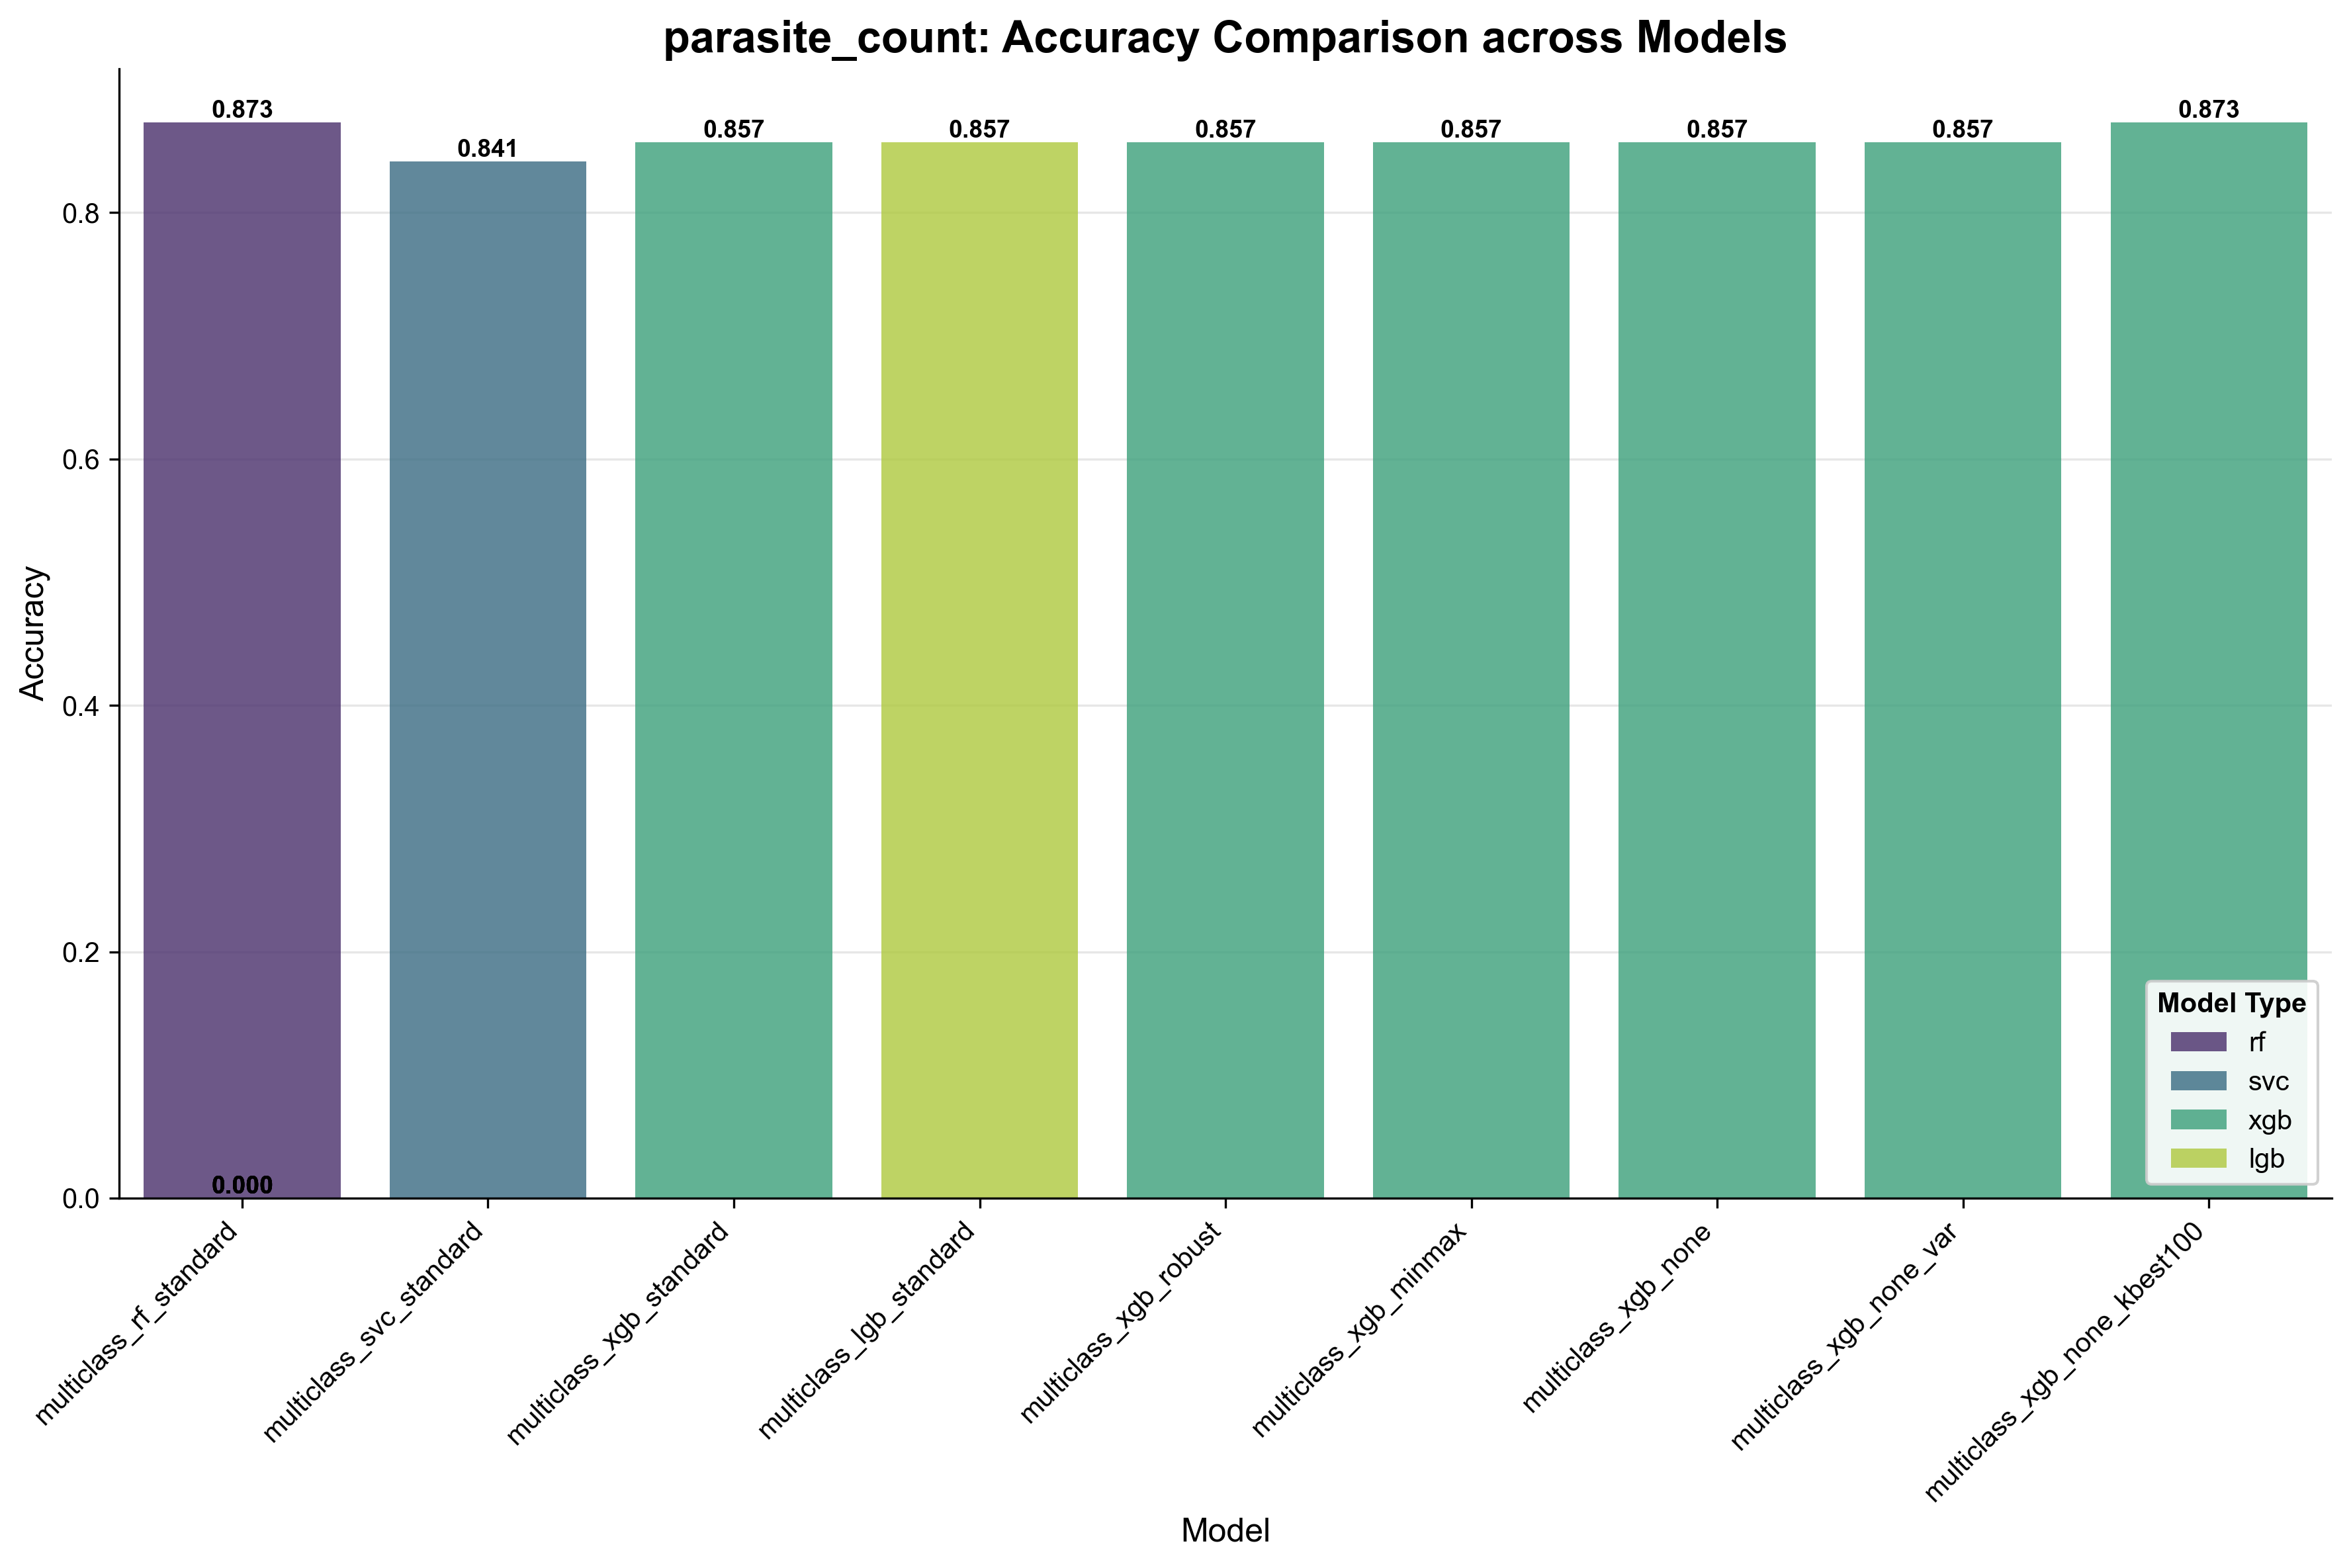

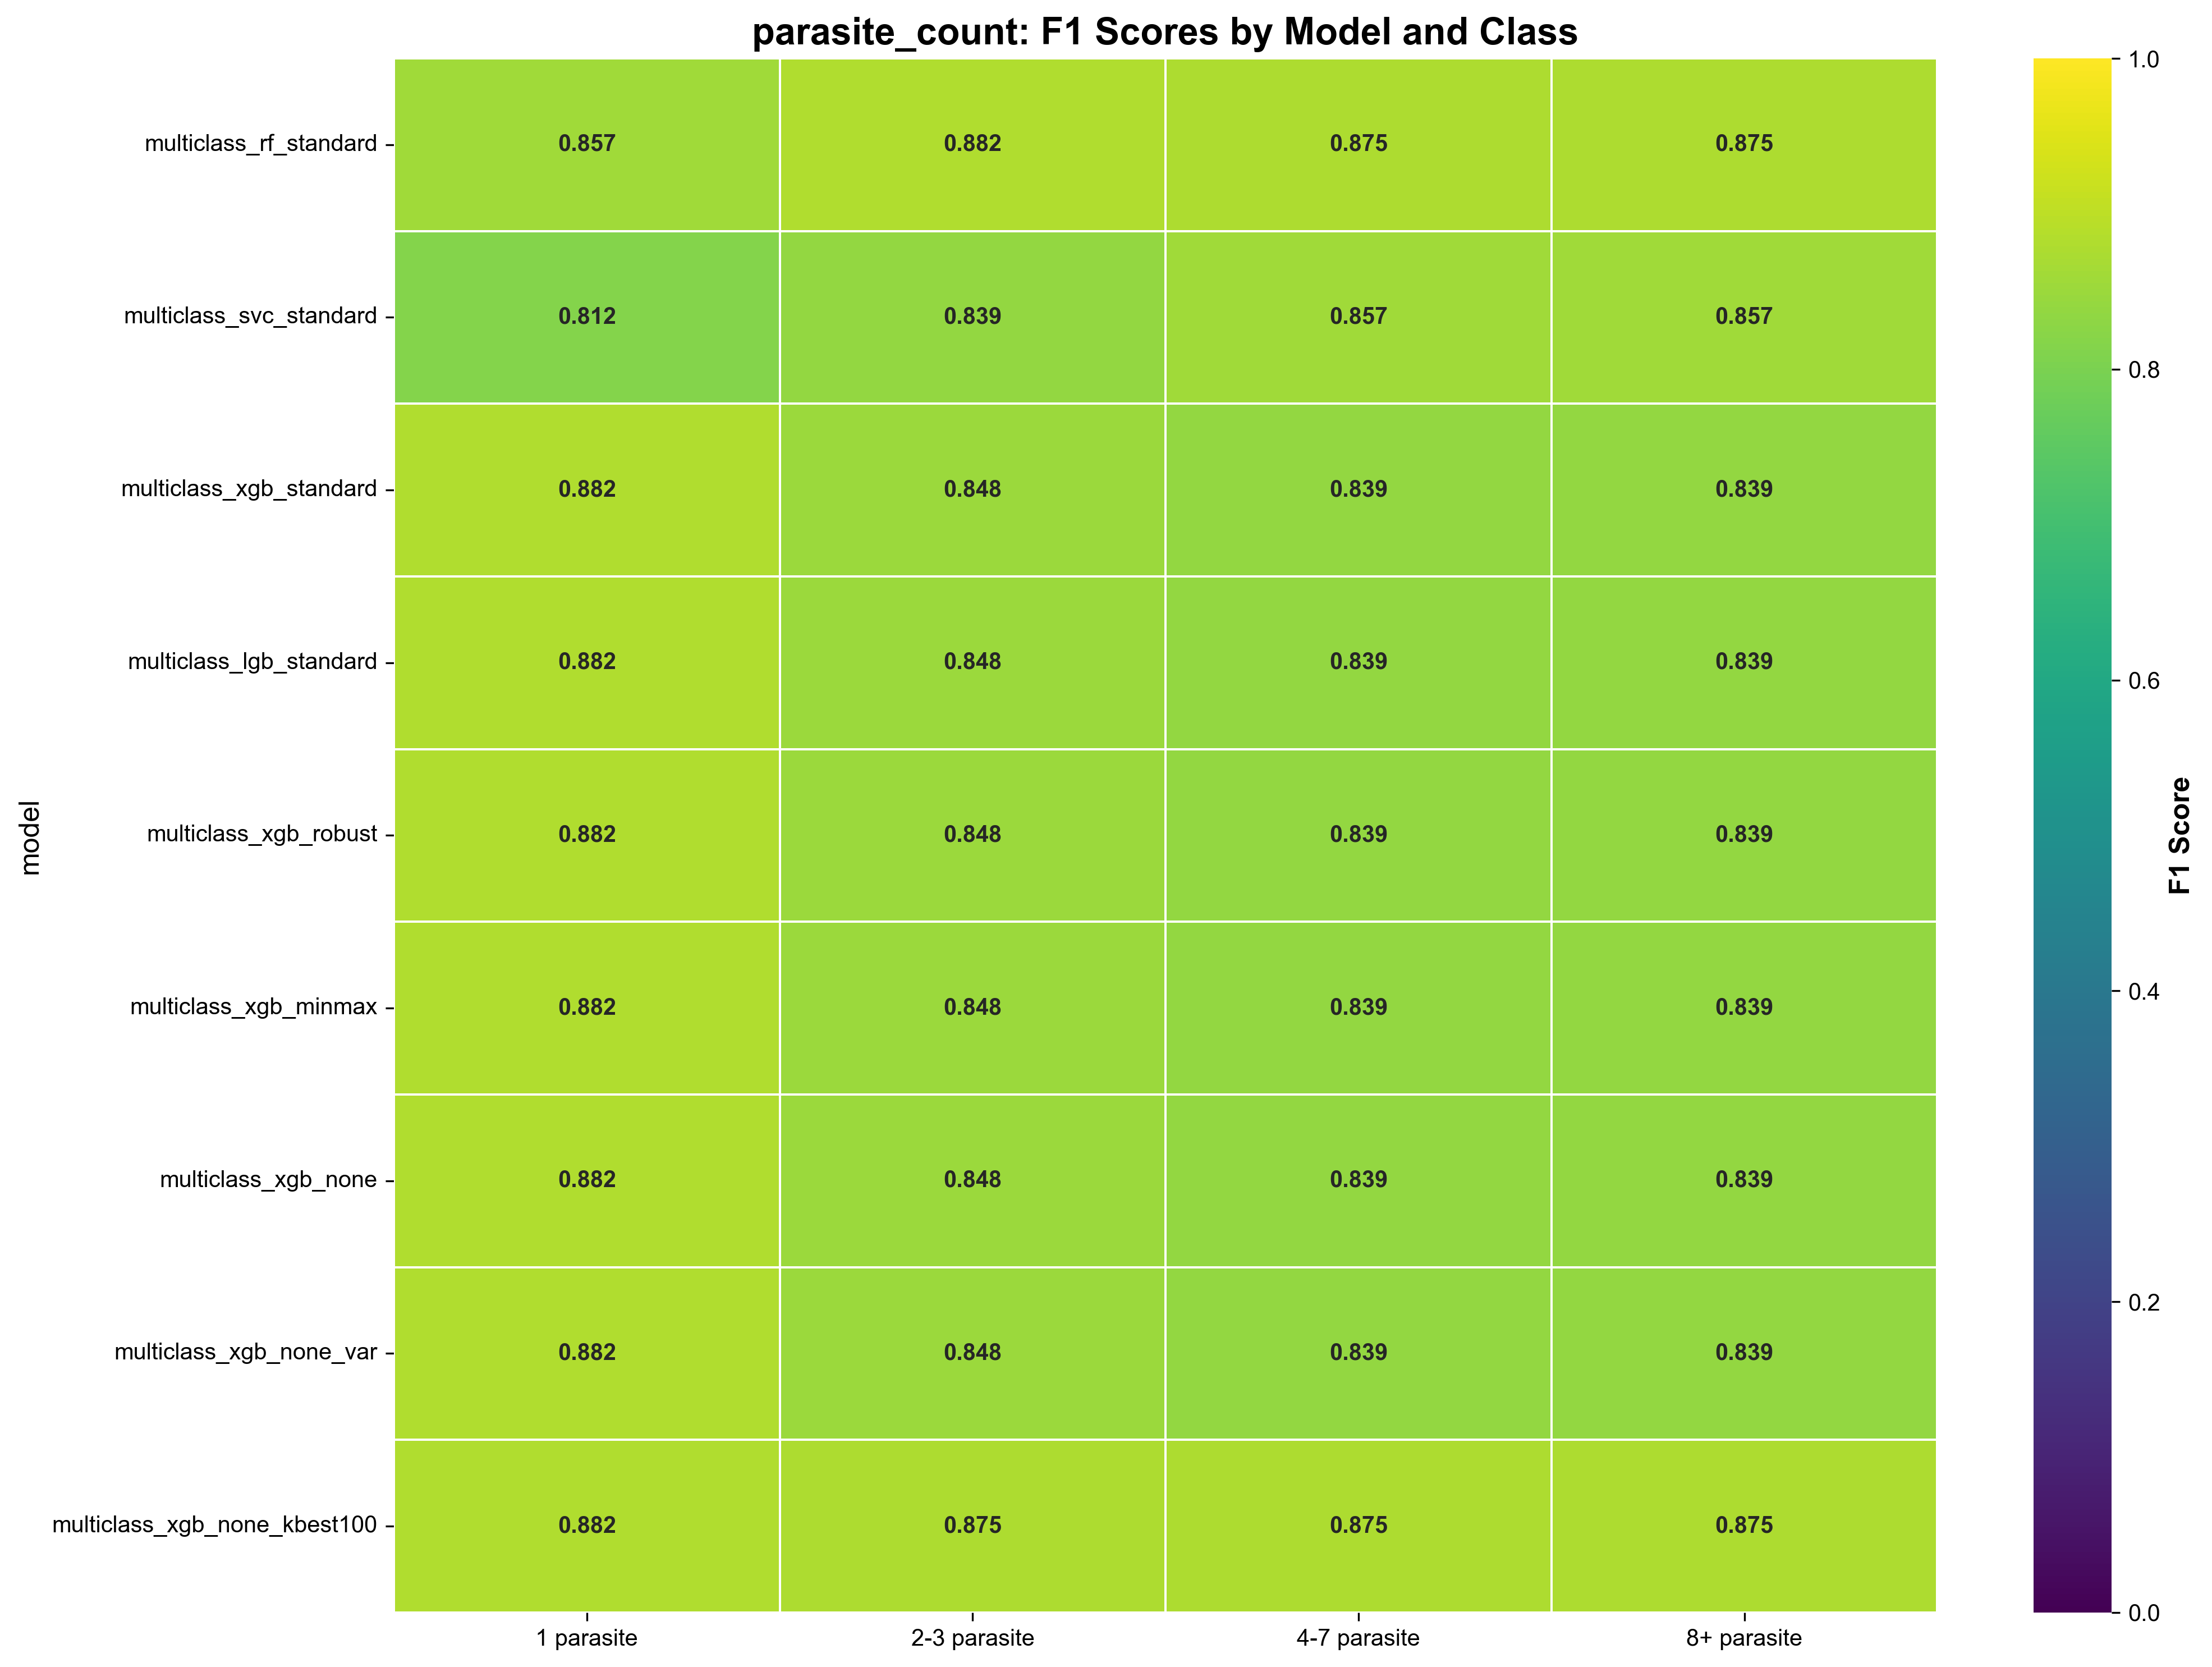

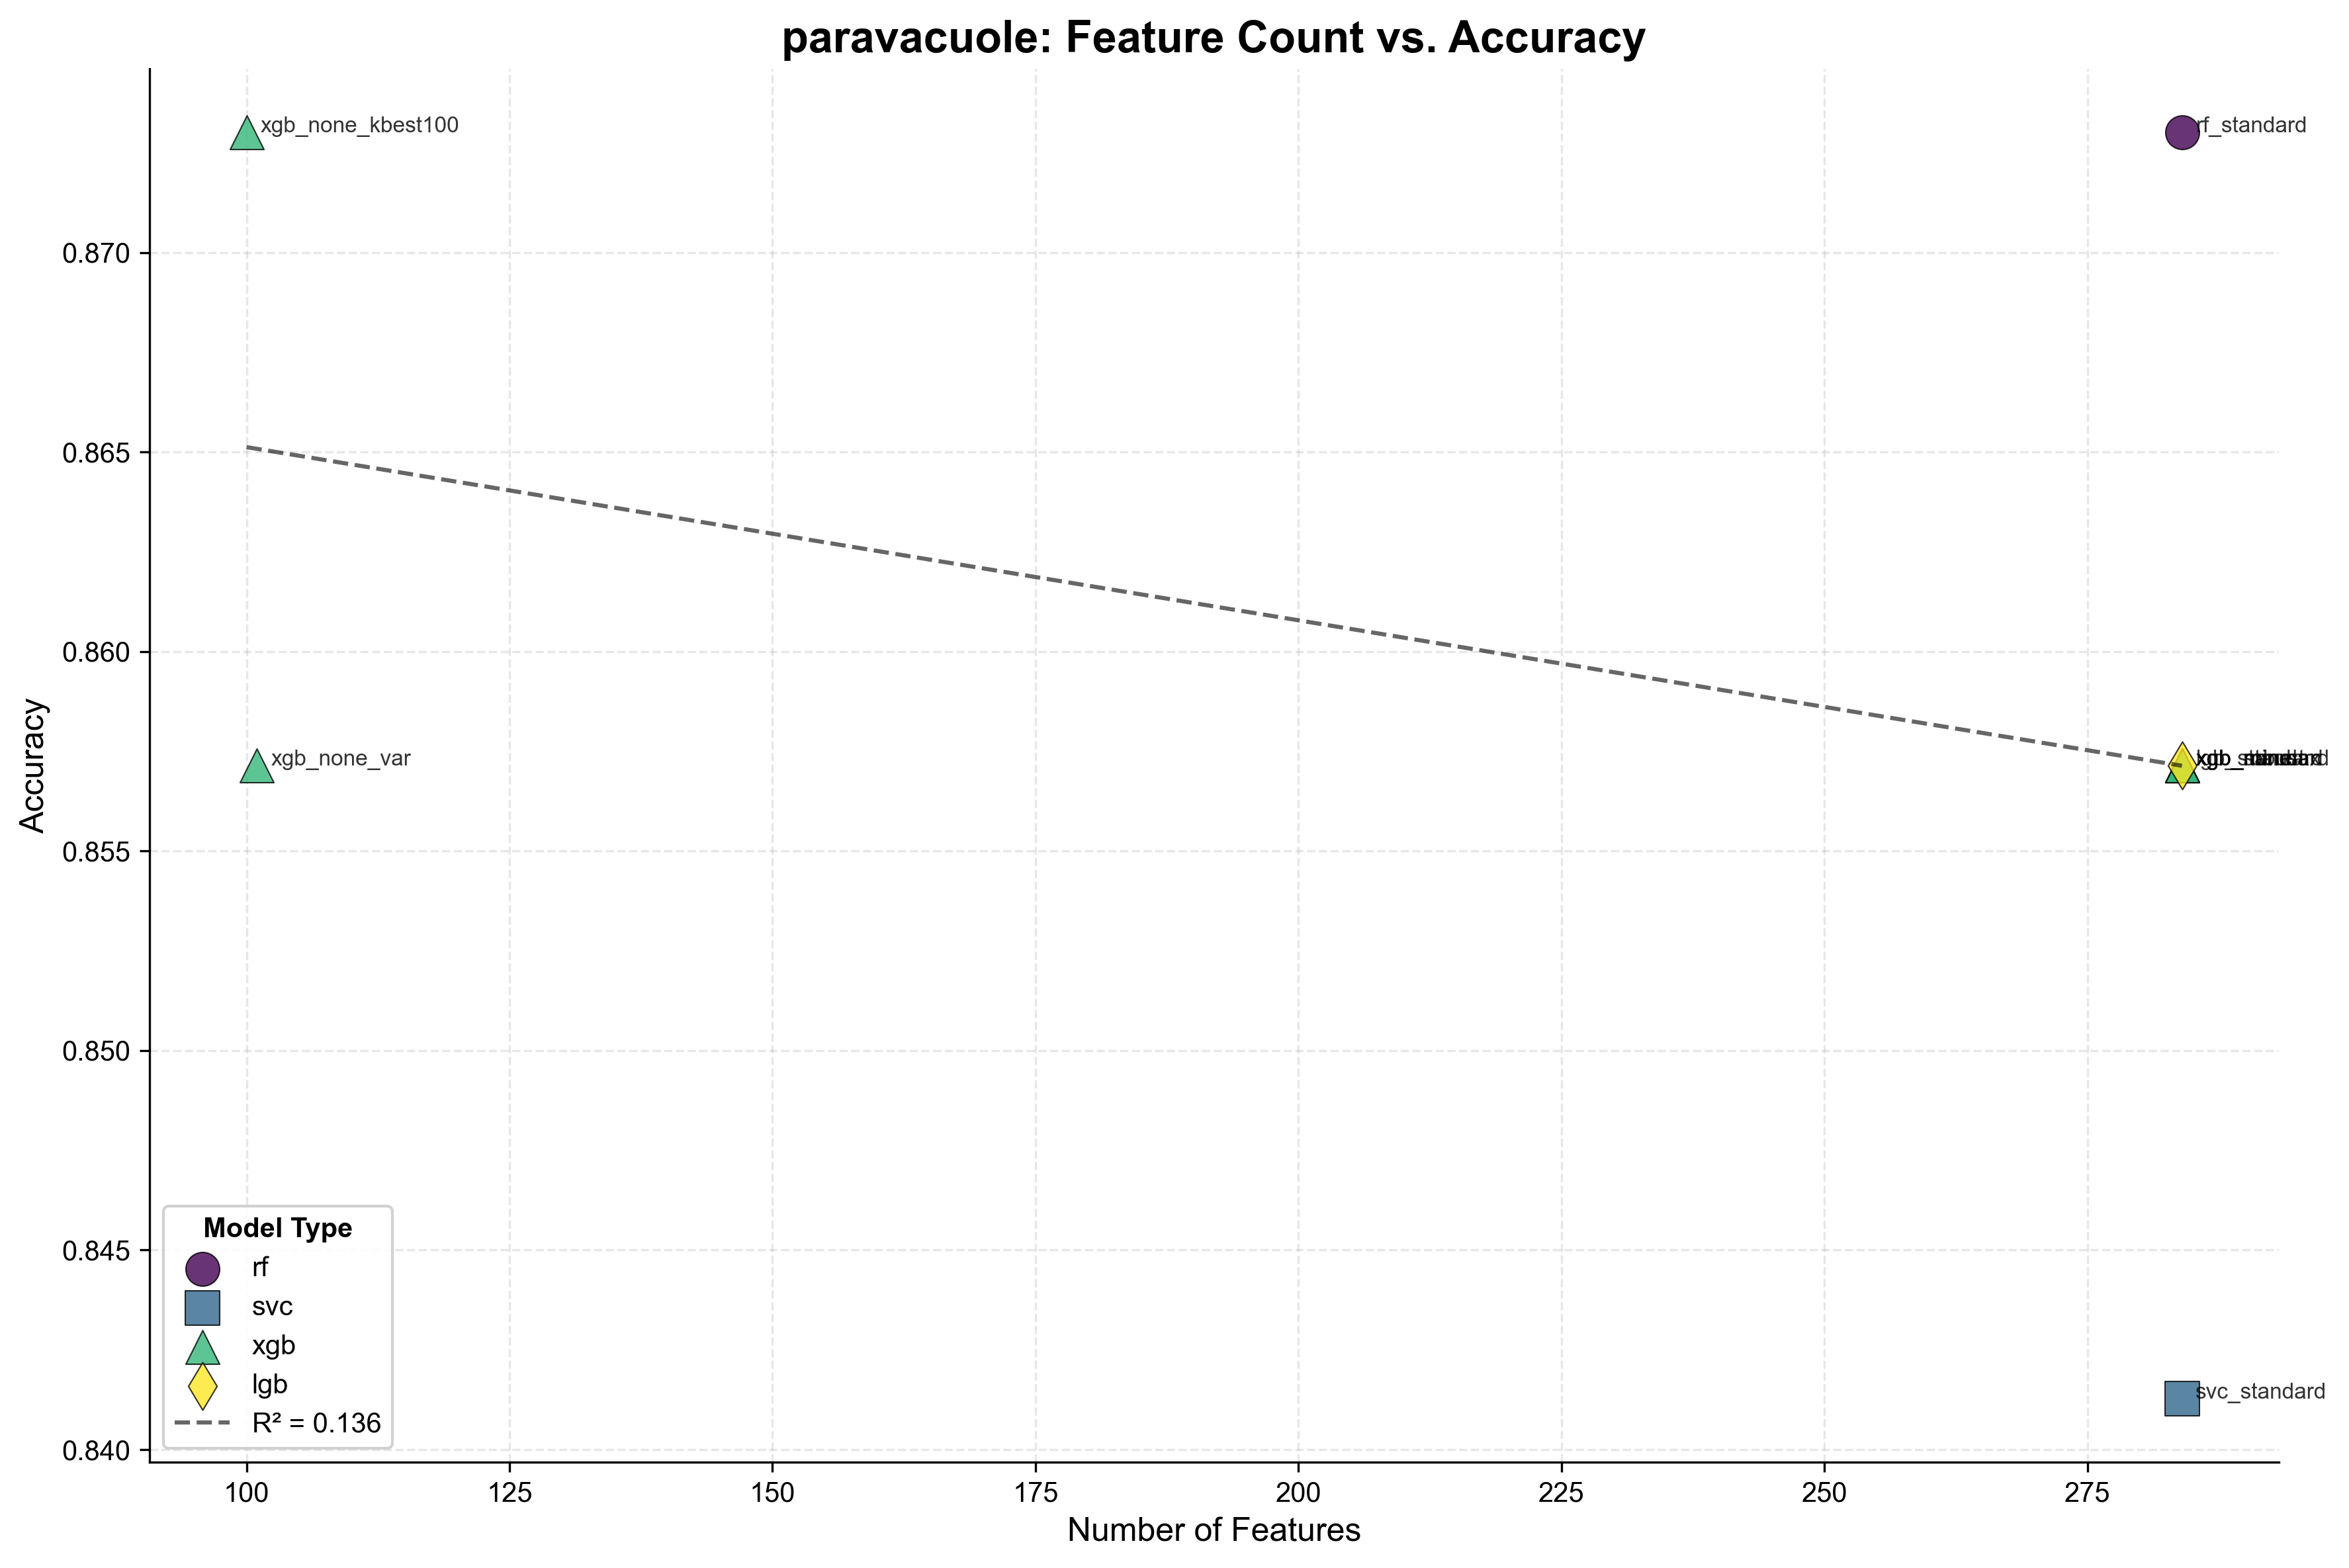

Available models:
multiclass_rf_standard
multiclass_svc_standard
multiclass_xgb_standard
multiclass_lgb_standard
multiclass_xgb_robust
multiclass_xgb_minmax
multiclass_xgb_none
multiclass_xgb_none_var
multiclass_xgb_none_kbest100


In [7]:
_=display_pngs_in_plots_and_list_models(
    CLASSIFIER_DIR_PATH, width=1200
)

Selected_model: multiclass_rf_standard


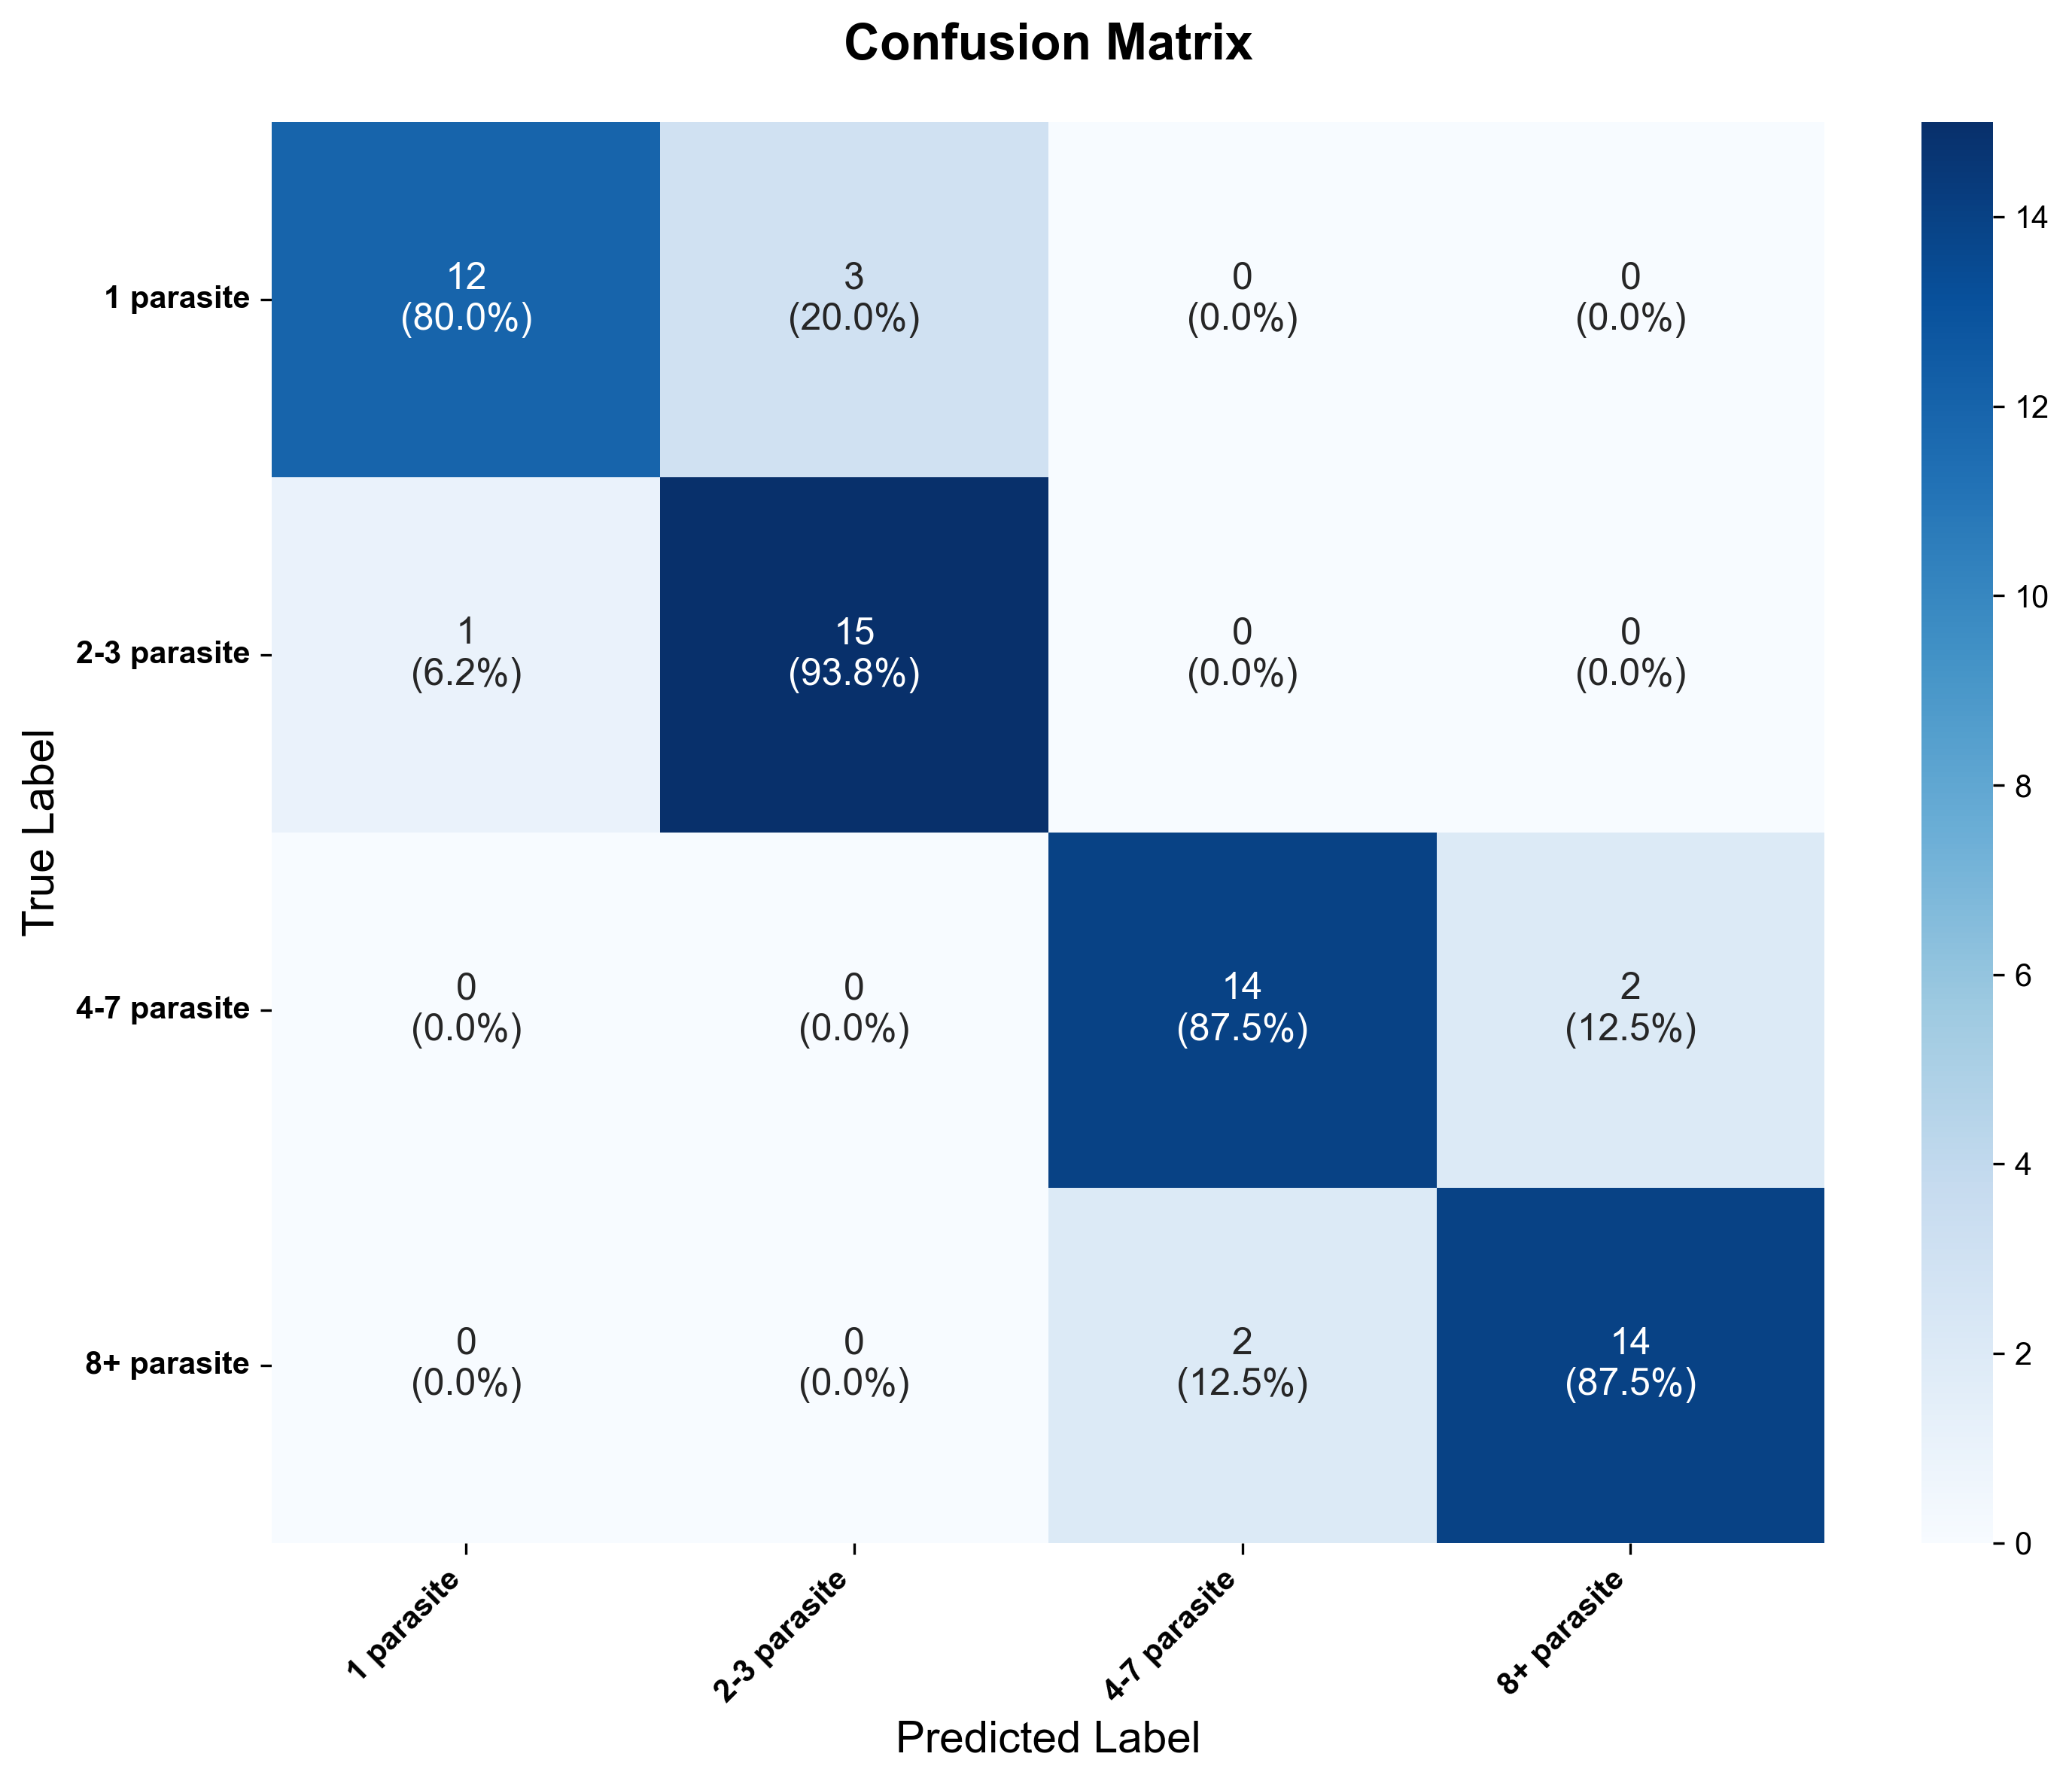

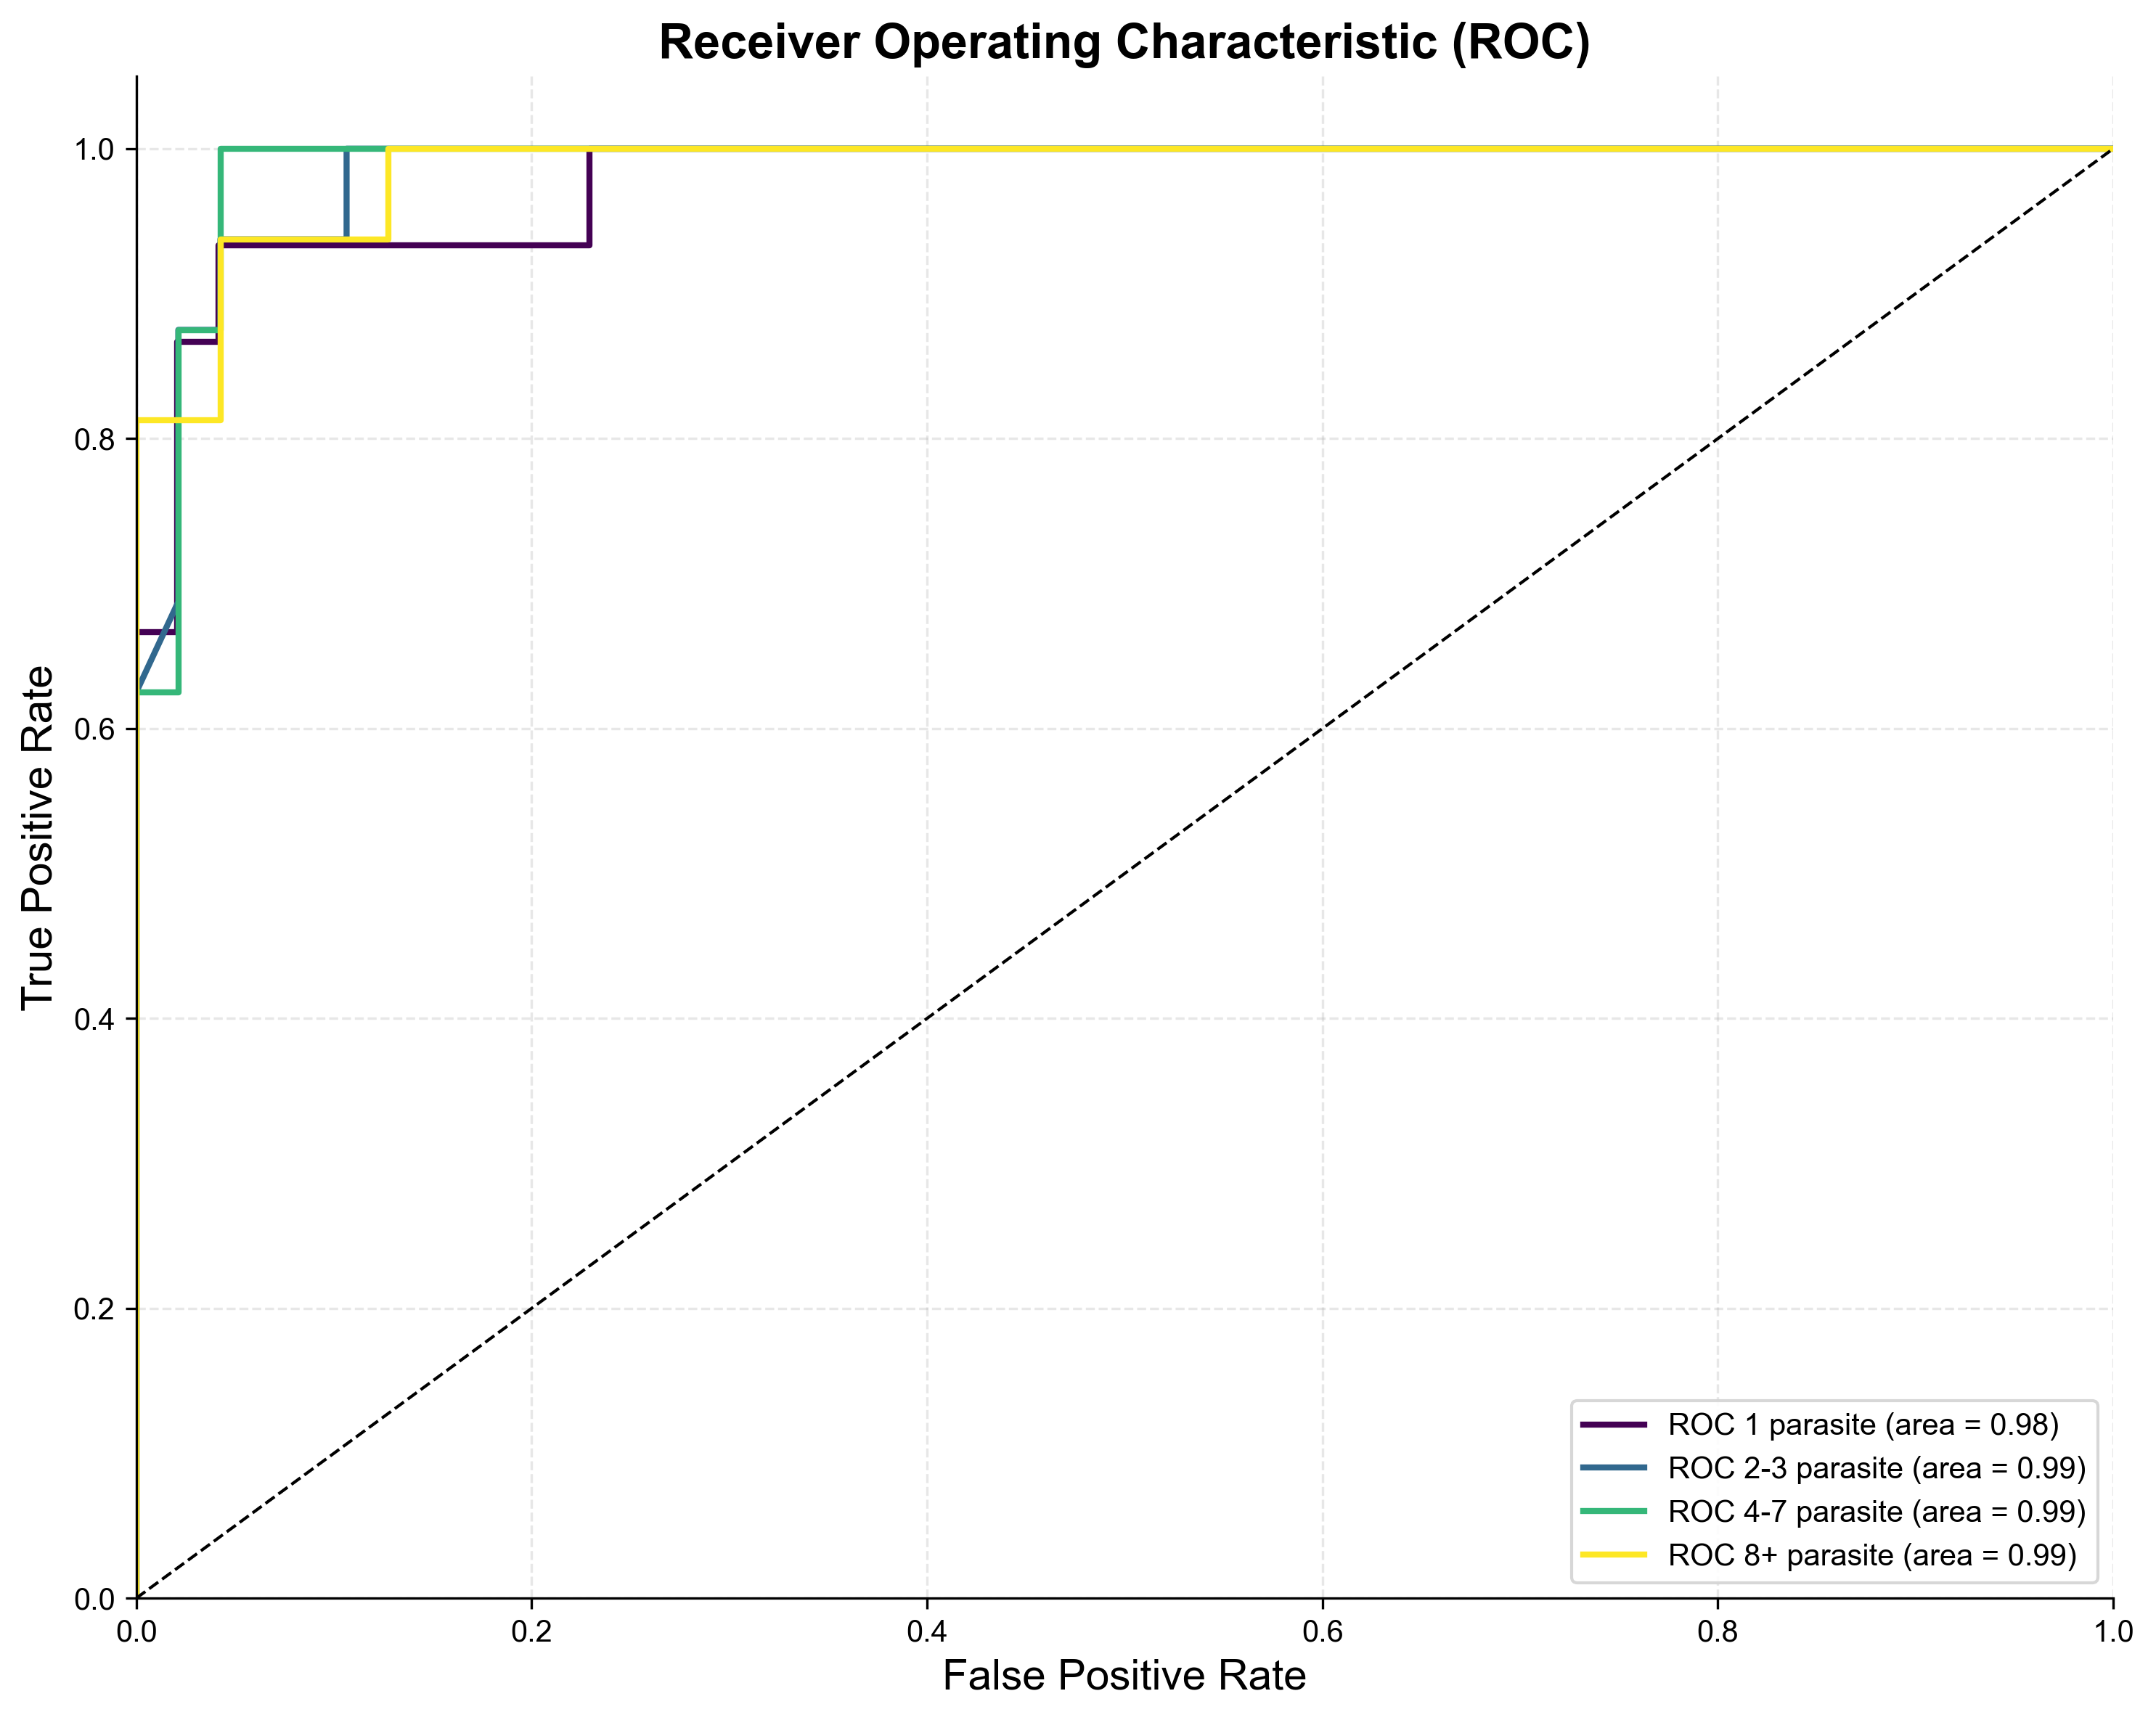

In [9]:
CLASSIFIER_MODEL = None
MONTAGE_CHANNEL = "CDPK1" #specify channel to use for montage image, should be one of the channels used for training
COLLAPSE_COLS = ["plate", "well"]
#=====================
CLASSIFIER_PATH, model_name = resolve_classifier_model_dill_path(CLASSIFIER_DIR_PATH, CLASSIFIER_MODEL)
print("Selected_model: " + model_name)
_ = show_model_evaluation_pngs(CLASSIFIER_DIR_PATH, model_name, width=500)

In [ ]:
# This cell applies the model to your test dataset
classifier = CellClassifier.load(CLASSIFIER_PATH)
classified_metadata, classified_features = classifier.classify_cells(metadata, features)

print(classified_metadata.head())
# Create config var for cell classes
CELL_CLASSES = list(classified_metadata[class_title].unique())

# Show cell class counts and distribution
print(class_title + " counts:")
print(classified_metadata[class_title].value_counts())

print("\n"+ class_title + " confidences:")
classified_metadata[class_title + "_confidence"].hist()
plt.show()

In [ ]:
CONFIDENCE_CORRECTION = None
CALIBRATION_DATASET_FP = None
CALIBRATION_METHOD = "isotonic" #options are "isotonic", "sigmoid"

In [ ]:
if CALIBRATION_DATASET_FP is not None:
    manual_labeled_data = load_cellprofiler_data(CALIBRATION_DATASET_FP)
else :
    print("No training dataset provided, using last classified dataset")
    CALIBRATION_DATASET_FP = config["train_classifier"]["training_datasets"]
    if CALIBRATION_DATASET_FP is None or len(CALIBRATION_DATASET_FP) == 0:
        raise ValueError("No calibration dataset provided and no training dataset found in config.")
    manual_labeled_data = load_cellprofiler_data(CALIBRATION_DATASET_FP)

classified_metadata, meta = calibrate_confidence(
    master_phenotype_df=master_phenotype_df,
    classified_metadata=classified_metadata,
    manual_labeled_data=manual_labeled_data,
    classify_by=classify_by,                 # 'cell' or 'vacuole'
    class_title=class_title,                 # e.g., 'pred_label'
    classifier_path=CLASSIFIER_PATH,         # path to your saved CellClassifier
    confidence_correction=CONFIDENCE_CORRECTION,  # None or 'post-hoc'
    calibration_method=CALIBRATION_METHOD,        # 'isotonic' or 'sigmoid'
    test_plate=plates,                   # or None
    test_well=wells,                     # or None
    min_samples_isotonic=50,
    verbose=True,
)

print(meta)


In [ ]:
fig, axes, montages, titles, ORDERED_CLASSES, summary_df = build_montages_and_summary(
    master_phenotype_df=master_phenotype_df,
    classified_metadata=classified_metadata,
    classify_by=classify_by,
    class_mapping=class_mapping,
    class_title=class_title,
    root_fp=ROOT_FP,
    channels=config["phenotype"]["channel_names"],
    montage_channel=MONTAGE_CHANNEL,
    collapse_cols=COLLAPSE_COLS,
    verbose=True,
    show_figure=True,
    display_fn=display,  # optional
)

In [ ]:
DISPLAY_CHANNEL = ["CDPK1", "DAPI"]
CHANNEL_COLORS = ["r", "c"]
SCALE_BAR = 30
MINIMUM_DIFFERENCE = 0.001

In [ ]:
w = launch_rankline_ui(
    classified_metadata=classified_metadata,  # or raw classified_metadata
    class_title=class_title,
    classify_by=classify_by,
    class_mapping=class_mapping,
    phenotype_output_fp=PHENOTYPE_OUTPUT_FP,
    channel_names=list(config["phenotype"]["channel_names"]),
    display_channels=DISPLAY_CHANNEL,
    channel_colors=CHANNEL_COLORS,
    test_plate=plates,
    test_well=wells,
    scale_bar_px=SCALE_BAR,          # or scale_bar_um=SCALE_BAR_UM, pixel_size_um=PIXEL_SIZE_UM
    minimum_difference=MINIMUM_DIFFERENCE,
    thumbnail_px=150,
    auto_display=True,                  # shows it immediately
)
# You can also: display(w)

Running the next config cell will save your confidence interval and the selected model to config file, to apply the code

In [ ]:
CONFIDENCE_THRESHOLD  = 0.59
print("Currently applied model:" + model_name)

In [ ]:
# ---- append fields under train_classifier (no checks) ----
config["train_classifier"].update({
    "CLASSIFIER_MODEL": str(CLASSIFIER_MODEL),
    "CLASSIFIER_PATH": str(CLASSIFIER_PATH),
    "CONFIDENCE_THRESHOLD": CONFIDENCE_THRESHOLD,
})

# Convert tuples to lists before dumping
safe_config = convert_tuples_to_lists(config)

# Write the updated configuration back with markdown-style comments
with open(CONFIG_FILE_PATH, "w") as config_file:
    config_file.write("")
    yaml.safe_dump(safe_config, config_file, sort_keys=False, default_flow_style=False)

print("Updated config['train_classifier'] with classifier apply settings.")